In [120]:
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()
print(help(SmilesEnumerator))

Help on class SmilesEnumerator in module SmilesEnumerator:

class SmilesEnumerator(builtins.object)
 |  SmilesEnumerator(charset='@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False)
 |
 |  SMILES Enumerator, vectorizer and devectorizer
 |
 |  Methods defined here:
 |
 |  __init__(self, charset='@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  fit(self, smiles, extra_chars=[], extra_pad=5)
 |      Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
 |
 |  randomize_smiles(self, smiles)
 |      Perform a randomization of a SMILES string
 |
 |  reverse_transform(self, vect)
 |      Performs a conversion of a vectorized SMILES to a smiles strings
 |
 |  transform(self, smiles)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors define

In [121]:
for i in range(10):
    print(sme.randomize_smiles("CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2"))

c1([C@@]2(OC(=O)CC)CC[NH+](C)C[C@H]2CC=C)ccccc1
C(O[C@]1(c2ccccc2)CC[NH+](C)C[C@H]1CC=C)(=O)CC
C1[C@@H](CC=C)[C@](c2ccccc2)(OC(=O)CC)CC[NH+]1C
[C@@]1(OC(=O)CC)(c2ccccc2)CC[NH+](C)C[C@H]1CC=C
c1([C@]2(OC(=O)CC)[C@H](CC=C)C[NH+](C)CC2)ccccc1
[NH+]1(C)C[C@@H](CC=C)[C@](c2ccccc2)(OC(=O)CC)CC1
C=CC[C@H]1[C@@](OC(=O)CC)(c2ccccc2)CC[NH+](C)C1
[C@H]1(CC=C)[C@@](OC(=O)CC)(c2ccccc2)CC[NH+](C)C1
c1cccc([C@]2(OC(=O)CC)[C@H](CC=C)C[NH+](C)CC2)c1
c1cc([C@]2(OC(CC)=O)[C@H](CC=C)C[NH+](C)CC2)ccc1


In [122]:
import numpy as np
smiles = np.array(["CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2"])
print(smiles.shape)

(1,)


In [123]:
sme.fit(smiles)
print(sme.charset)
print(sme.pad)

1O@HN(c]=2[C)+
50


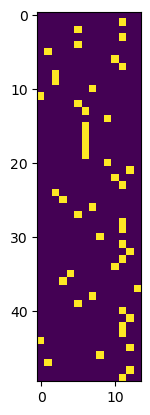

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
vect = sme.transform(smiles)
plt.imshow(vect[0])

True False


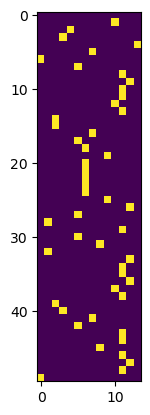

In [125]:
print(sme.enumerate, sme.canonical)
vect = sme.transform(smiles)
plt.imshow(vect[0])

In [126]:
print(sme.reverse_transform(vect))

['[NH+]1(C)CC[C@@](c2ccccc2)(OC(=O)CC)[C@H](CC=C)C1']


In [127]:
import os
import pandas as pd
# file_path = './data/train.csv'
df = pd.read_csv('./data/train.csv')


In [128]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

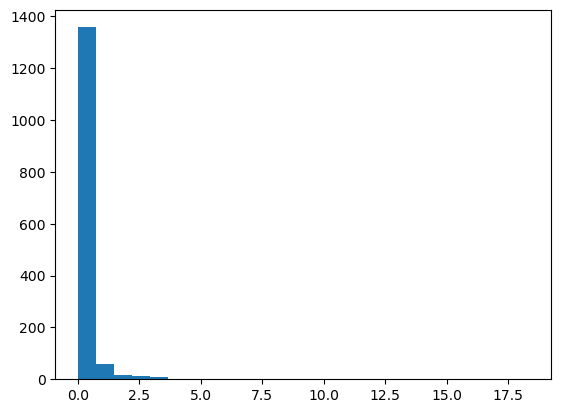

In [99]:
#정규화 다시하기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import numpy as np

# SMILES 데이터와 IC50_nM 값을 랜덤하게 분할
X_train,  X_test, y_train, y_test = train_test_split(df['Smiles'],
                                                     df['IC50_nM'].values.reshape(-1,1),
                                                     random_state=42)

# y_train과 y_test에 포함된 문자열을 숫자로 변환하기 위한 전처리
# 공백 제거
y_train = np.char.replace(y_train.astype(str), ' ', '')
y_test = np.char.replace(y_test.astype(str), ' ', '')

# 부동 소수점으로 변환
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# RobustScaler를 사용하여 데이터 스케일링
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train = rbs.fit_transform(y_train)
y_test = rbs.transform(y_test)

# y_train 값의 히스토그램 출력
_ = plt.hist(y_train, bins=25)
plt.show()

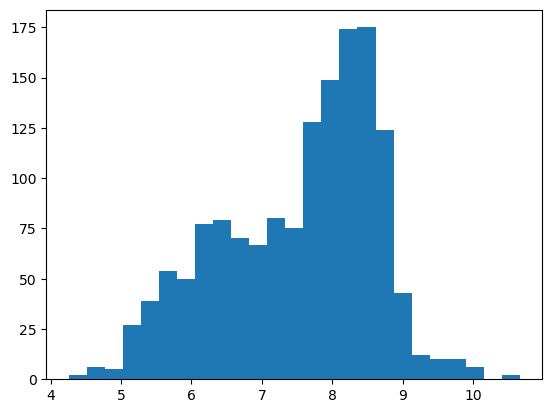

In [131]:
# 정규화 없이
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# SMILES 데이터와 IC50_nM 값을 랜덤하게 분할
X_train,  X_test, y_train, y_test = train_test_split(df['Smiles'],
                                                     df['pIC50'].values.reshape(-1,1),
                                                     random_state=42)

# y_train 값의 히스토그램 출력
_ = plt.hist(y_train, bins=25)
plt.show()

# 모델 학습에 바로 사용 가능


In [132]:
import tensorflow.keras.backend as K
from SmilesEnumerator import SmilesIterator
#The SmilesEnumerator must be fit to the entire dataset, so that all chars are registered
sme.fit(df["Smiles"], extra_chars=["9"])
sme.leftpad = True
print(sme.charset)
print(sme.pad)
#The dtype is set for the K.floatx(), which is the numerical type configured for Tensorflow or Theano
generator = SmilesIterator(X_train, y_train, sme, batch_size=200, dtype=K.floatx())

O/N(4PH[+oB3.\1758@-s]nSC6F9l#c2=)r
150


In [133]:
X,y = generator.next()
print(X.shape)
print(y.shape)

(200, 150, 35)
(200, 1)


In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop

In [135]:
# model.compile(loss="mse", optimizer=RMSprop(lr=0.005))


In [136]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

In [137]:
input_shape = X.shape[1:]
output_shape = 1

model = Sequential()
model.add(LSTM(64,
               input_shape=input_shape,
               dropout = 0.19
               #unroll= True
              ))
model.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(learning_rate=0.005))
print(model.summary())

/data/2_data_server/cv-07/anaconda3/envs/koreatech/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,665 (100.25 KB)

 Trainable params: 25,665 (100.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [138]:
def custom_generator(generator):
    while True:
        inputs, targets = next(generator)
        #print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        yield inputs, targets

In [139]:
model.fit(custom_generator(generator), 
          steps_per_epoch=100, 
          epochs=25)


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 6.9615
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 1.3113
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 1.2845
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 1.2786
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1.2563
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 1.2549
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 1.2448
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1.2050
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1.0732
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1.0693
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 0.9745
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 1.0558
Epoch 13/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.8954
Epoch 14/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 0.9096
Epoch 15/25
100

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/stepWARNING:tensorflow:5 out of the last 77 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f30906f7560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
0.10106625
[[-0.99315498]
 [-0.44315498]
 [-2.07315498]
 [-0.91315498]
 [ 1.30684502]
 [ 1.17684502]
 [-0.59315498]
 [ 1.01684502]
 [ 0.37684502]
 [ 1.30684502]
 [ 1.25684502]
 [-0.98315498]
 [-0.4931

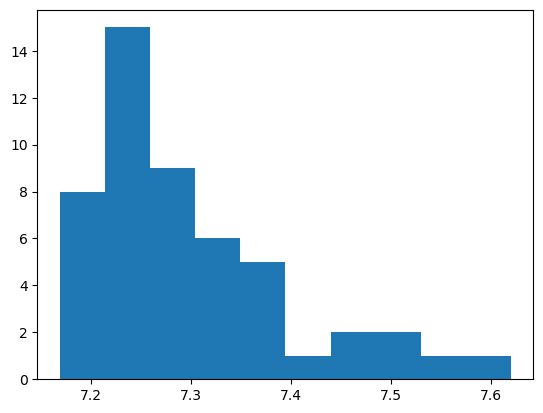

In [140]:
#Enumeration of the SMILES before sampling stabilises the result
smiles_repeat = np.array([X_test.iloc[i:i+1].values[0]]*50)
y_true = y_test
y_pred = model.predict(sme.transform(smiles_repeat))
print(y_pred.std())
print(y_true - np.median(y_pred))
_ = plt.hist(y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


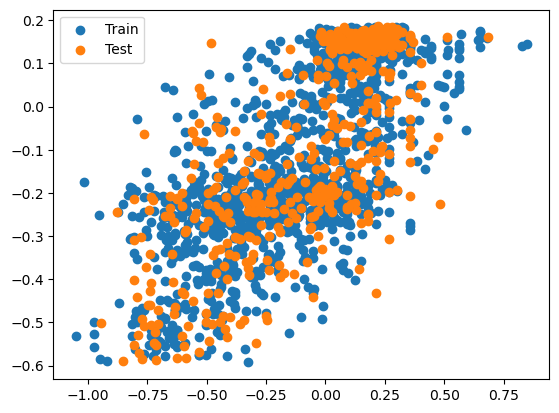

In [59]:
y_pred_train = model.predict(sme.transform(X_train))
y_pred_test = model.predict(sme.transform(X_test))
plt.scatter(y_train, y_pred_train, label="Train")
plt.scatter(y_test, y_pred_test, label="Test")
plt.legend()

In [149]:
df_test = pd.read_csv('./data/test.csv')

In [154]:
pred = df_test["Smiles"]

In [155]:
sample = pd.read_csv('./data/sample_submission.csv')

In [156]:
pred_ = model.predict(sme.transform(pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [145]:
def pIC50_to_IC50_nM(pIC50_values):
    return 10**(9 - pIC50_values)

In [157]:
pred_value = pIC50_to_IC50(pred_)

In [159]:
sample['IC50_nM'] = pred_value

In [160]:
sample.to_csv('./sample.csv', index=False)

In [50]:
#sample.to_csv('./sample.csv', index=False)

In [64]:
sample.head()

,ID,IC50_nM
0,TEST_000,-0.248934
1,TEST_001,-0.075912
2,TEST_002,-0.146543
3,TEST_003,0.076595
4,TEST_004,-0.113854


In [148]:
result = model.predict(sme.transform(pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [52]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

In [53]:
result_ = pIC50_to_IC50(result)

In [65]:
sample['IC50_nM'] = result

In [66]:
sample.to_csv('./sample.csv', index=False)

In [57]:
sample.head()

,ID,IC50_nM
0,TEST_000,1.872027e+09
1,TEST_001,9.414966e+08
2,TEST_002,1.009064e+09
3,TEST_003,1.028012e+09
4,TEST_004,9.983544e+08
